In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.special as special
from scipy.integrate import cumtrapz
from tabulate import tabulate
from tabulate import tabulate


In [118]:
#Hourly Weater from Ennis, MT in 2016. From BigQuery
e_weather = pd.read_csv('ennis_weather_hourly_2016.csv') 
e_weather.rename(columns={'time_valid_utc': 'time', 
'temperature_air_2m_f': 'temp'},inplace = True)
e_weather.drop('dst_offset_minutes', inplace=True, axis = 1)

Text(0, 0.5, 'Temperature')

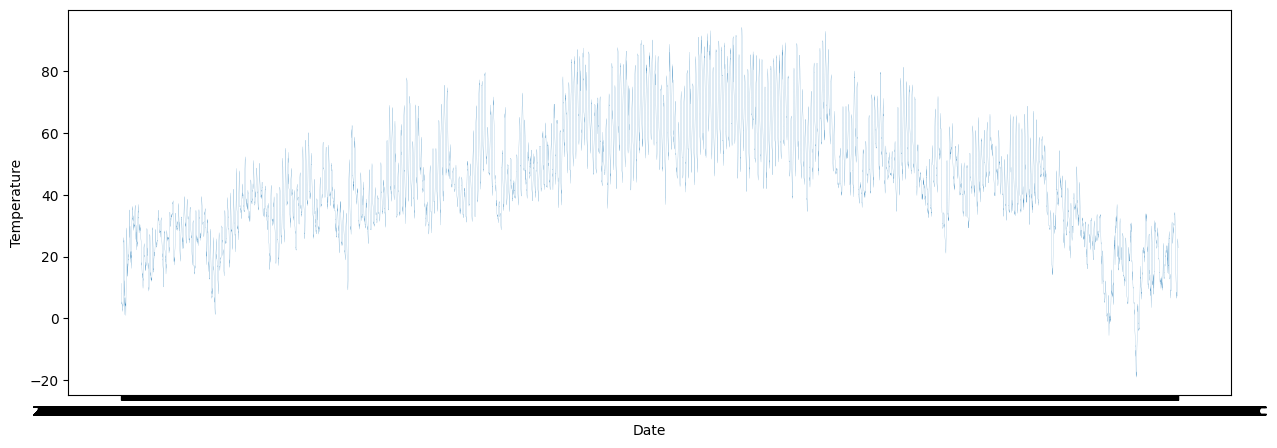

In [119]:
#Temperature Plot for 2016, visualized
plt.figure(figsize=(15,5))
plt.plot(e_weather.time, e_weather.temp, linewidth='.1' )
plt.xlabel("Date")
plt.ylabel('Temperature')

In [121]:
# The structure should always be at least 50 degrees Farhenheit. The "Baseline Temperature" will then be 50
e_weather['baseline_temp'] = 50

#The difference between the observed temperature and baseline will be calculated.
#If this number is negative (observed temp is less than 50), it will be assumed that the sturcture will need to be "heated" for this hour
# If a "heating hour" is required, 1 will be assigned to the particular hour
e_weather['difference']= e_weather.temp - e_weather.baseline_temp
e_weather['heating_hour']= np.where(e_weather['difference'] < 0, 1, 0)

#The sum of "heating_hour" reveals the estimated number of heating hours
#This sum is only slightly lower (~12%) compared to the number of heating hours estimate by observing the high and low temps for each day (as opposed to the increase granularity providing by hourly observations)
sum(e_weather['heating_hour'])

5382

In [122]:
heating_hours = e_weather
heating_hours['time']=pd.to_datetime(heating_hours.time)

#Calculates estimated # of heating hours needed each day
total_heating_hours=heating_hours.groupby(heating_hours.time.dt.date).agg(
             {'heating_hour': 'sum'}).reset_index()

Text(0, 0.5, 'Number of Projected Heating Hours')

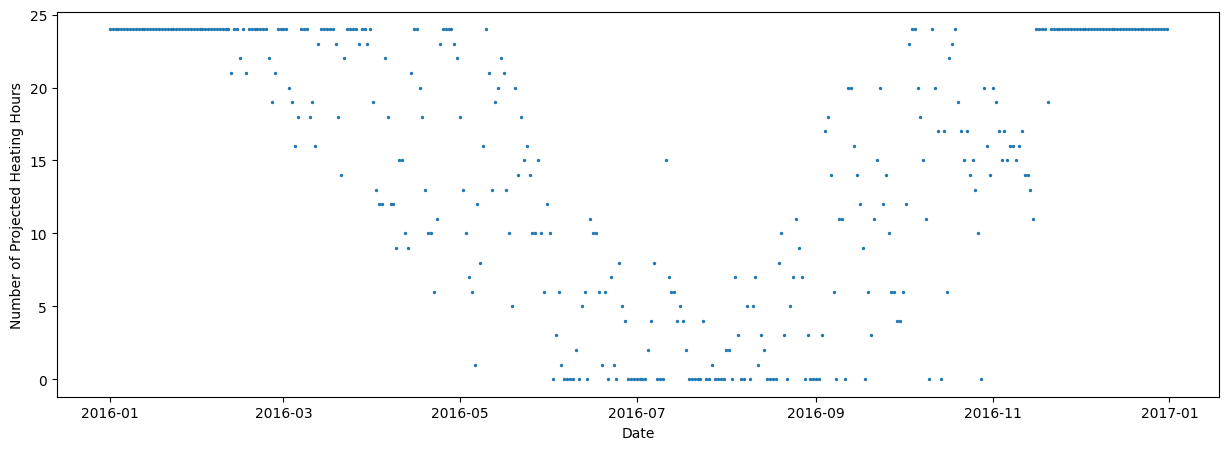

In [123]:
plt.figure(figsize=(15,5))
plt.scatter(total_heating_hours.time, total_heating_hours.heating_hour, s=2, alpha=1)
plt.xlabel("Date")
plt.ylabel('Number of Projected Heating Hours')

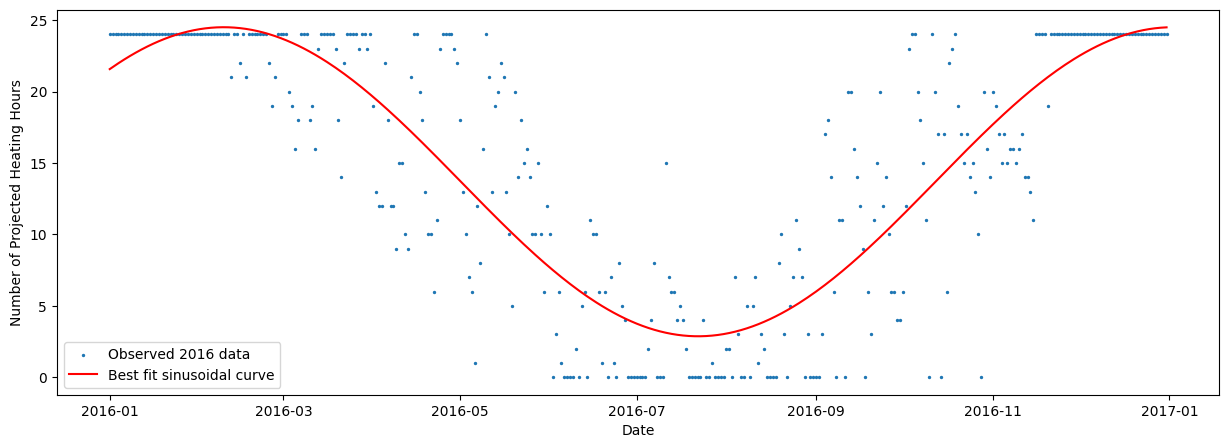

In [127]:
from turtle import color

plt.figure(figsize=(15,5))

# 'model' function for number of heating hours. Sinusoudal function was chosen. In further iterations, simple linear piecewise functions may better capture the trapuzoidal shape of the data
def bestfit(x, A, b, phi, c):
	y = A*np.sin(b*x+phi) + c
	return y
initial = (24, .00137, 0, 3.14)

param, pcov = curve_fit(bestfit, total_heating_hours.index, total_heating_hours.heating_hour, initial)

bestfitsine = param[0]*np.sin(param[1]*total_heating_hours.index+param[2]) + param[3]


plt.scatter(total_heating_hours.time, total_heating_hours.heating_hour, s=2, alpha=1, label ="Observed 2016 data")
plt.plot(total_heating_hours.time, bestfitsine, color='r', label="Best fit sinusoidal curve")
plt.xlabel("Date")
plt.ylabel('Number of Projected Heating Hours')
plt.legend()


In [128]:
#Integrating best fit line for the predicted number of heating hours using observed data
#Result = ~5359 or within .4% of the agregated 2016 data
bestfitsinelambda = lambda x: param[0]*np.sin(param[1]*x+param[2]) + param[3]

estimated_heating_hours = integrate.quad(bestfitsinelambda, 0, 365)
print(estimated_heating_hours)
print(sum(total_heating_hours.heating_hour))

(5358.976441143047, 5.94965903338079e-11)
5382


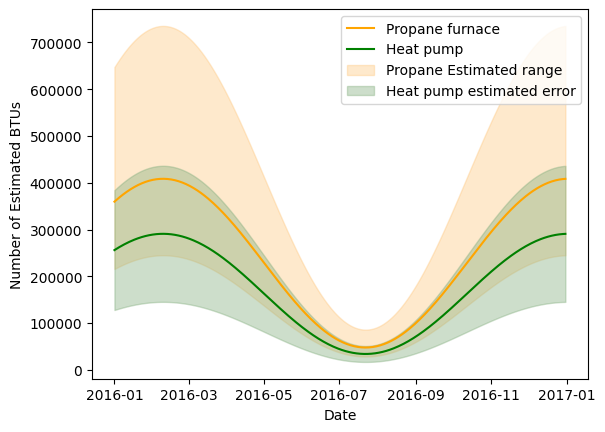

In [130]:
#Estimated BTUs used for a ~50,000 BTU/hr capacity propane heater and heat pump

#Propane coefficient: Estimated mean run time of 20 minutes per hour (.33hr), 50,000*.33 = ~16,667 BTU's needed for every 'heating hour'

#Heat Pump coefficient: Based HSPF of 9.2, 48,000 BTU capacity heat pump (@17 degrees Farhenheit) -> 5.217 kwH. Estimated mean run time of 40 min per hour -> 2.6085 kwH are
#needed per'heating hour'. As there are 3412.14 BTUs per 1kwH -> heat pump will need  ~ 11,870 BTUs per 'heating hour'

# Propane BTU error based on estimated use of 3-8, 4 min cylces per heating hour
from cProfile import label


p=(50000)*(20/60)
pl=(50000)*(12/60)
ph=(50000)*(36/60)

# Heatpump BTU error based on estimated use of 2-3, 10-20 min cycles
h=(5.217)*(2/3)*(3412.14)
hl=(5.217)*(1/3)*(3412.14)
hh = (5.217)*(1)*(3412.14)

plt.plot(total_heating_hours.time, p*bestfitsine, color = 'orange', label="Propane furnace")
plt.plot(total_heating_hours.time, h*bestfitsine, color = 'g', label="Heat pump")



plt.fill_between(total_heating_hours.time, pl*bestfitsine,  ph*bestfitsine,
                 color='#fec880', alpha=0.4, label= 'Propane Estimated range')
plt.fill_between(total_heating_hours.time, hl*bestfitsine,  hh*bestfitsine,
                 color='#83ae7e', alpha=0.4, label ="Heat pump estimated error")

plt.xlabel("Date")
plt.ylabel('Number of Estimated BTUs')
plt.legend()

Text(0.5, 1.0, 'Estimated cost per day of running a Propane Furnace vs Heatpump')

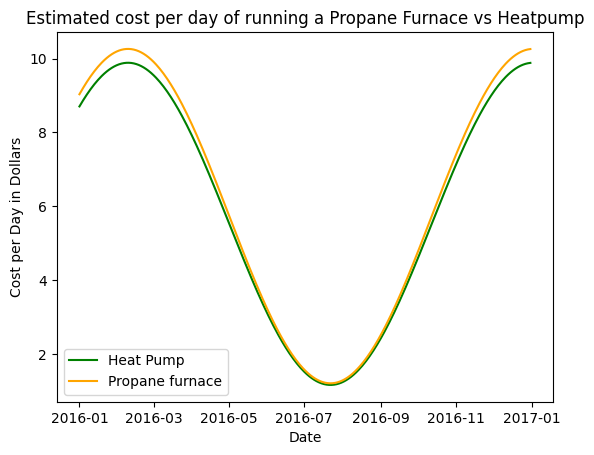

In [159]:
#Price Comparison; based on estimated $.116 per kwH and $2.299 per gallon of propane
h_price= (h/3412.14)*.116
h_price_low=(hl/3412.14)*.116
h_price_high=(hh/3412.14)*.116

p_price= (p/91502)*2.299
p_price_low=(pl/91502)*2.299
p_price_high=(ph/91502)*2.299


plt.plot(total_heating_hours.time, h_price*bestfitsine, color = 'g' , label ="Heat Pump")
plt.plot(total_heating_hours.time, p_price*bestfitsine, color = 'orange', label="Propane furnace")
plt.xlabel("Date")
plt.ylabel('Cost per Day in Dollars')

plt.legend()
plt.title('Estimated cost per day of running a Propane Furnace vs Heatpump')


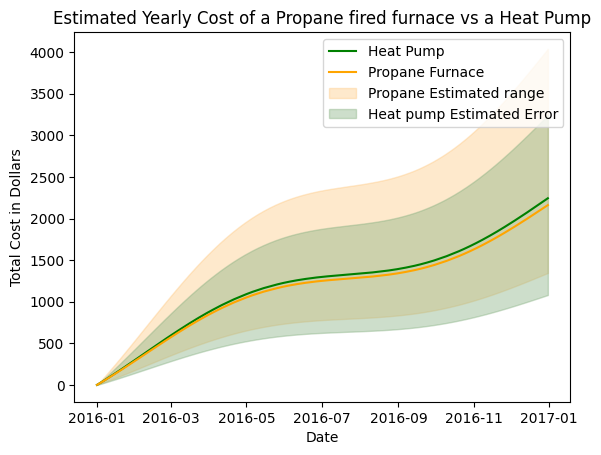

In [160]:
bestfitsinelambda = lambda x: param[0]*np.sin(param[1]*x+param[2]) + param[3]

estimated_heating_hours = integrate.quad(bestfitsinelambda, 0, 365)

def total_cost(x): 
    c= integrate.quad(bestfitsinelambda, 0, x)
    return c


def P(x):
    res = np.zeros_like(x)
    for i,val in enumerate(x):
        y,err = integrate.quad(bestfitsinelambda,0,val)
        res[i]=y
    return res
def H(x):
    res = np.zeros_like(x)
    for i,val in enumerate(x):
        y,err = integrate.quad(bestfitsinelambda,0,val)
        res[i]=y
    return res

plt.plot(total_heating_hours.time, p_price* P(total_heating_hours.index), color = 'g', label="Heat Pump")
plt.plot(total_heating_hours.time, h_price*H(total_heating_hours.index), color = 'orange', label= "Propane Furnace")


plt.fill_between(total_heating_hours.time, p_price_low*P(total_heating_hours.index),  p_price_high*P(total_heating_hours.index),
                 color='#fec880', alpha=0.4, label = 'Propane Estimated range')
plt.fill_between(total_heating_hours.time, h_price_low*H(total_heating_hours.index),  h_price_high*H(total_heating_hours.index),
                 color='#83ae7e', alpha=0.4, label="Heat pump Estimated Error")


plt.xlabel("Date")
plt.ylabel('Total Cost in Dollars')
plt.title("Estimated Yearly Cost of a Propane fired furnace vs a Heat Pump")
plt.legend()

In [106]:
print(total_cost(365))

(5358.976441143047, 5.94965903338079e-11)


In [158]:
#Cost Analysis over time
#Heat Pump Cost: 3,339.99 https://www.minisplitwarehouse.com/product/cooper-hunter-48000-btu-17-seer-light-commercial-grade-slim-ducted-mini-split-heat-pump-ac
# Propane Heater Cost: 2,837.99 https://www.grainger.com/product/NEXUS-Gas-Wall-and-Ceiling-Unit-55GY93
ct, e =total_cost(365)

cost_analysis = pd.DataFrame(columns=['Propane', 'Heat Pump'])
cost_analysis.loc[1]= [2837.99,3339.99]
cost_analysis.loc[2]= [p_price_low*ct, h_price_low*ct]
cost_analysis.loc[3]= [p_price*ct,h_price*ct]
cost_analysis.loc[4]= [p_price_high*ct, h_price_high*ct]

cost_analysis =round(cost_analysis,2)

low_range= [round(p_price_low*ct + 2837.99,2), round(h_price_low*ct + 3339.99,2)]
high_range= [round(p_price_high*ct + 2837.99,2), round(h_price_high*ct+ 3339.99,2)]

cost_analysis.loc[5]= ["$" +str(low_range[0])+ " - "+ "$" +str(high_range[0]), "$" +str(low_range[1])+ " - "+"$" +str(high_range[1])]

cost_analysis.index = ['Unit Cost', "Low Estimate", 'Estimate', 'High Estimate', 'Total']


print(tabulate(cost_analysis, headers = ['Propane', 'Heat Pump'], tablefmt='fancy_grid'))

╒═══════════════╤═════════════════════╤═════════════════════╕
│               │ Propane             │ Heat Pump           │
╞═══════════════╪═════════════════════╪═════════════════════╡
│ Unit Cost     │ 2837.99             │ 3339.99             │
├───────────────┼─────────────────────┼─────────────────────┤
│ Low Estimate  │ 1346.45             │ 1081.03             │
├───────────────┼─────────────────────┼─────────────────────┤
│ Estimate      │ 2244.08             │ 2162.07             │
├───────────────┼─────────────────────┼─────────────────────┤
│ High Estimate │ 4039.35             │ 3243.1              │
├───────────────┼─────────────────────┼─────────────────────┤
│ Total         │ $4184.44 - $6877.34 │ $4421.02 - $6583.09 │
╘═══════════════╧═════════════════════╧═════════════════════╛
